# Setup

In [52]:
from qutip import *
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.nonparametric.kernel_regression import KernelReg

# t-opt

In [167]:
dim = 50
f = 0.1
γ = 15
# γlist = [10, 15, 20, 25, 30]
γlist = [10, 20, 30]
replist = [100]#[10, 50, 100, 200, 300, 400, 500, 1000]
nh = 1e7
fbsb = 5
Nbsbs = 1
tbsb = np.linspace(0, (2 * (Nbsbs-1) + 1) / (4 * fbsb), 100)
c_ops = lambda γ: [np.sqrt(γ*1e-10 * (nh + 1)) * tensor(qeye(2), destroy(dim)), np.sqrt(γ*1e-10 * nh) * tensor(qeye(2), create(dim))]
sl = 25
t = np.linspace(0, 50, 5000)
print(γ*1e-10*nh)

0.015


In [168]:
H = tensor(qeye(2), qeye(dim))
Hbsb = lambda ϕ: 2 * np.pi * fbsb * (np.exp(1j * ϕ) * tensor(sigmap(), create(dim)) + np.exp(-1j * ϕ) * tensor(sigmam(), destroy(dim)))
X = Qobj([[1, -1], [1, 1]] / np.sqrt(2))
Xtot = tensor(X, qeye(dim))
ρi_list = []
ρi = tensor(ket2dm(np.sqrt(0.3) * basis(2, 0) + np.sqrt(0.7) * basis(2, 1)), thermal_dm(dim, 0.07))
# ρi_test = tensor(ket2dm(basis(2, 1)), thermal_dm(dim, 0.077))

In [169]:
bsb_res = mesolve(Hbsb(np.pi/2), ρi, tbsb, [], [])
# bsb_res = mesolve(Hbsb(np.pi/2), ρi_test, tbsb, c_ops1, [])
ρi = bsb_res.states[-1]

0.035969537423206785
0.03735104681085059


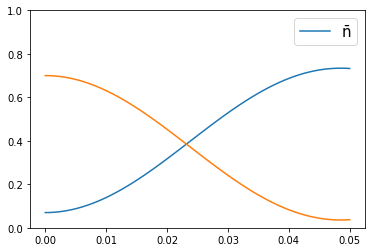

In [170]:
yspin = [expect(tensor(num(2), qeye(dim)), state) for state in bsb_res.states]
plt.plot(tbsb, [expect(tensor(qeye(2), num(dim)), state) for state in bsb_res.states], label="n̄")
plt.plot(tbsb, yspin)
plt.ylim(0, 1)
plt.legend(fontsize=15)
print(np.min(yspin))
print(yspin[-1])

In [171]:
results = []
for γ in γlist:
    results.append(mesolve(H, ρi, t, c_ops(γ), []))

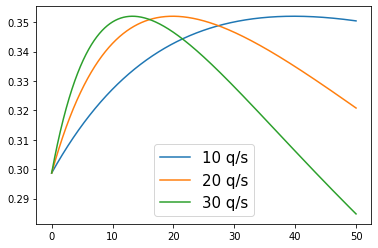

In [172]:
for i,γ in enumerate(γlist):
    plt.plot(t, [expect(tensor(qeye(2), ket2dm(basis(dim, 0))), state) for state in results[i].states], label="{} q/s".format(γ))
plt.legend(fontsize=15)

In [173]:
pops = []
popsdown = []
for i,res in enumerate(results):
    rotated_res = []
    for state in res.states[::sl]:
        res = mesolve(Hbsb(np.pi/2), state, tbsb, c_ops(γlist[i]), [])
        rotated_res.append( Xtot * res.states[-1] * Xtot.dag())
    pops.append([np.real(state.ptrace(0)[0, 0]) for state in rotated_res]) 
    popsdown.append([np.real(state.ptrace(0)[1, 1]) for state in rotated_res]) 

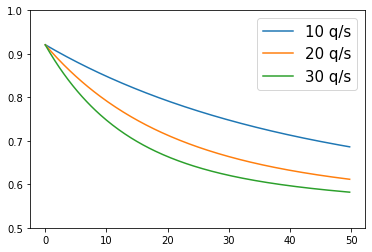

In [174]:
for i,pop in enumerate(pops):
    plt.plot(t[::sl], pop, label="{} q/s".format(γlist[i]))
plt.ylim(0.5, 1)
plt.legend(fontsize=15)

In [175]:
np.save("t_from_sim", t[::sl])

In [176]:
N = len(t[::sl])
ϕstdlist = []
for reps in replist:
    reps = int(reps)
    ϕstds = []
    for pop in pops:
        ϕstd = []
        for i in range(N):
            ϕs = []
            for j in range(10000):
                x0 = np.mean(np.random.binomial(1, 0.5, reps))
                x1 = np.mean(np.random.binomial(1, pop[i], reps))
                x2 = np.mean(np.random.binomial(1, 0.5, reps))
                B = (x0 + x2) / 2
                M = x0 - B
                D = x1 - B
                ϕs.append(np.arctan2(M, D))
            ϕstd.append(np.std(ϕs))
        ϕstds.append(ϕstd)
    ϕstdlist.append(ϕstds)

In [177]:
rep_i = 0
reps = replist[rep_i]
print(reps)
for i,γ in enumerate(γlist):
    x = np.sqrt(reps) * np.array(ϕstdlist[rep_i][i][1:]) / ((t[::sl][1:] * 1e-3)**(1/2)) / (2 * np.pi)
    np.save("topt_from_sim{}".format(γ), x)

100


In [178]:
def smooth(y, box_pts):
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y, box, mode='same')
    return y_smooth

reps 100, min: 1.96 @ 13.00


Text(0.5, 1.0, 'Heating Rate: 20 quanta/s')

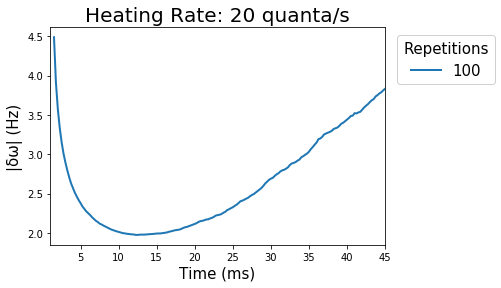

In [179]:
# reps comparison plot
γ_i = 1
smoothy_i = 10
for i,L in enumerate(ϕstdlist):
    reps = int(replist[i])
    y = np.sqrt(replist[i]) * np.array(L[γ_i][1:]) / ((t[::sl][1:] * 1e-3)**(1/2)) / (2 * np.pi)
    smooth_y = smooth(y, smoothy_i)
    print("reps {}, min: {:.2f} @ {:.2f}".format(reps, min(y), t[::sl][np.argmin(y)]))
#     kr = KernelReg(y, t[::sl][1:], 'c')
#     y_pred, y_std = kr.fit(t[::sl][1:])
#     smooth_y = smooth(y_pred, 3)
    I = smoothy_i // 2
    plt.plot(t[::sl][I+1:-I], smooth_y[I:-I], lw=2, marker="o", ms=0, label="{}".format(reps))
plt.legend(title="Repetitions", title_fontsize=15, fontsize=15, loc=1, framealpha=0.9, bbox_to_anchor=(1.35,1))
# plt.xlim(0, 40)
plt.ylabel("|δω| (Hz)", fontsize=15)
plt.xlabel("Time (ms)", fontsize=15)
# plt.ylim(0, 10)
plt.xlim(1,45)
plt.title("Heating Rate: {} quanta/s".format(γlist[γ_i]), fontsize=20)

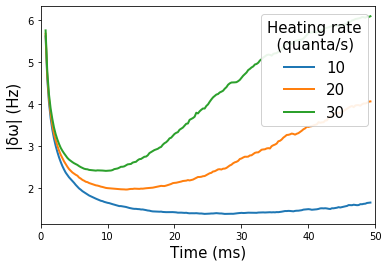

In [194]:
#γ comparison plot
rep_i = 0
reps = replist[rep_i]
ϕstds = ϕstdlist[rep_i]
smoothy_i = 5
for i,L in enumerate(ϕstds):
    y = np.sqrt(reps) * np.array(L[1:]) / ((t[::sl][1:] * 1e-3)**(1/2)) / (2 * np.pi)
    smooth_y = smooth(y, smoothy_i)
#     kr = KernelReg(y, t[::sl][1:], 'c')
#     y_pred, y_std = kr.fit(t[::sl][1:])
#     smooth_y = smooth(y_pred, 3)
    I = smoothy_i // 2
    plt.plot(t[::sl][I+1:-I], smooth_y[I:-I], lw=2, marker="o", ms=0, label="{}".format(γlist[i]))
    np.save("topt_from_sim{}".format(γlist[i]), smooth_y[I:-I])
plt.legend(title="Heating rate\n  (quanta/s)", title_fontsize=15, fontsize=15, loc=1, framealpha=0.9)
# plt.xlim(0, 40)
plt.ylabel("|δω| (Hz)", fontsize=15)
plt.xlabel("Time (ms)", fontsize=15)
plt.xlim(0,50)

np.save("t_from_sim", t[::sl][I+1:-I])
    

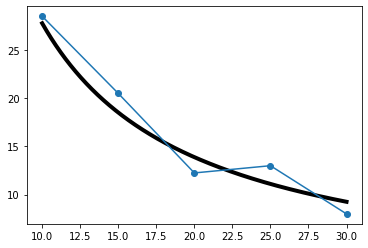

In [41]:
ϕstdmins_finite_temp_contrast = []
for l in ϕstds:
    ϕstdmins_finite_temp_contrast.append(t[::sl][1:][np.argmin(l[1:] / (t[::sl][1:]**(1/2)))])
plt.plot(γlist, ϕstdmins_finite_temp_contrast, marker="o")

gg = np.linspace(10, 30, 1000)
plt.plot(gg, 1/(3.6 * gg * 1e-3), color="k", lw=4, zorder=-1)

# Envelope Sim

In [29]:
H = tensor(qeye(2), qeye(dim))
Hbsb = lambda ϕ: 2 * np.pi * fbsb * (np.exp(1j * ϕ) * tensor(sigmap(), create(dim)) + np.exp(-1j * ϕ) * tensor(sigmam(), destroy(dim)))
X = Qobj([[1, -1], [1, 1]] / np.sqrt(2))
Xtot = tensor(X, qeye(dim))
ρi_list = []
ρi = tensor(ket2dm(np.sqrt(0.5) * basis(2, 0) + np.sqrt(0.5) * basis(2, 1)), thermal_dm(dim, 0.07))
# ρi_test = tensor(ket2dm(basis(2, 1)), thermal_dm(dim, 0.077))

In [30]:
bsb_res = mesolve(Hbsb(np.pi/2), ρi, tbsb, [], [])
# bsb_res = mesolve(Hbsb(np.pi/2), ρi_test, tbsb, c_ops1, [])
ρi = bsb_res.states[-1]

0.043928949605439326
0.04487796017951291


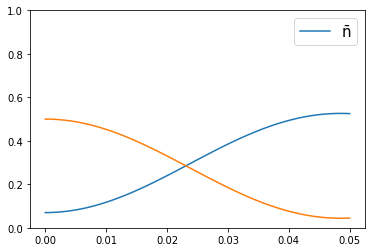

In [31]:
yspin = [expect(tensor(num(2), qeye(dim)), state) for state in bsb_res.states]
plt.plot(tbsb, [expect(tensor(qeye(2), num(dim)), state) for state in bsb_res.states], label="n̄")
plt.plot(tbsb, yspin)
plt.ylim(0, 1)
plt.legend(fontsize=15)
print(np.min(yspin))
print(yspin[-1])

In [184]:
results = []
for γ in γlist:
    results.append(mesolve(H, ρi, t, c_ops(γ), []))

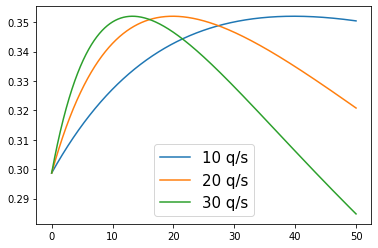

In [185]:
for i,γ in enumerate(γlist):
    plt.plot(t, [expect(tensor(qeye(2), ket2dm(basis(dim, 0))), state) for state in results[i].states], label="{} q/s".format(γ))
plt.legend(fontsize=15)

In [186]:
pops = []
popsdown = []
for i,res in enumerate(results):
    rotated_res = []
    for state in res.states[::sl]:
        res = mesolve(Hbsb(np.pi/2), state, tbsb, c_ops(γlist[i]), [])
        rotated_res.append( Xtot * res.states[-1] * Xtot.dag())
    pops.append([np.real(state.ptrace(0)[0, 0]) for state in rotated_res]) 
    popsdown.append([np.real(state.ptrace(0)[1, 1]) for state in rotated_res]) 

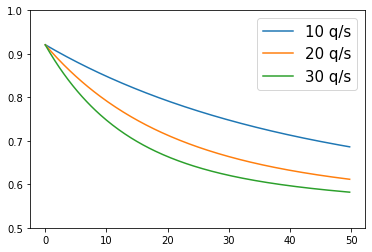

In [187]:
for i,pop in enumerate(pops):
    plt.plot(t[::sl], pop, label="{} q/s".format(γlist[i]))
plt.ylim(0.5, 1)
plt.legend(fontsize=15)

In [189]:
np.save("t_from_sim_decay_curve", t[::sl])
np.save("γlist", γlist)
for i,γ in enumerate(γlist):
    np.save("ramsey_decay_from_sim{}".format(γ), pops[i])
    np.save("ramsey_decay_down_from_sim{}".format(γ), popsdown[i])